In [15]:
# At first let's import necessary modules
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms



In [ ]:
# Let's download MNIST dataset and prepare form model training 
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())
# Reshape and normalize data
train_data = TensorDataset(train_data.data.view(-1, 28*28).float()/255.0, train_data.targets)
test_data = TensorDataset(test_data.data.view(-1, 28*28).float()/255.0, test_data.targets)

# Write one template how to make DataLoader for train and test datasets
# train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

# The initial DataLoader will be implemented in the train and evaluation sections

In [5]:
# Check if data is ok and GPU is available
print(f'Train data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')
print(f'CUDA available: {torch.cuda.is_available()}')

Train data size: 60000
Test data size: 10000
CUDA available: True


In [6]:
# Now as we don't have any problems with data, we can proceed to model creation and training
# Use base SimpleNN class implementation
class SimpleNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=[128, 64, 32], output_size=10, activation_fn=nn.ReLU, dropout_prob=0.1):
        super(SimpleNN, self).__init__()
        self.layers = []
        
        self.layers.append(nn.Linear(input_size, hidden_size[0]))
        for i in range(len(hidden_size) - 1):
            self.layers.append(activation_fn())
            self.layers.append(nn.Dropout(dropout_prob))
            self.layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
        self.layers.append(activation_fn())
        self.layers.append(nn.Dropout(dropout_prob))
        self.layers.append(nn.Linear(hidden_size[-1], output_size))
        self.model = nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
def train_and_evaluate( 
        hidden_layers=[128, 64],
        learning_rate=0.001,
        activation_fn=nn.ReLU,
        num_epochs=10,
        batch_size=32, 
        optimizer_class=optim.Adam,  
        criterion_class=nn.CrossEntropyLoss, 
        device='cuda',               
        show_plots=True,
        ):
    # Check device
    print(f'Training on device: {device}')

    # Our model
    model = SimpleNN(28*28, hidden_layers, 10, activation_fn).to(device)

    # DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

    # Optimizer and Loss function
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    loss_fn = criterion_class()

    # Keep history for optional plotting
    if show_plots:
        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct_train += pred.eq(target.view_as(pred)).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / len(train_loader.dataset)

        # Evaluate on test set
        model.eval()
        total_test_loss = 0
        correct_test = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = loss_fn(output, target)
                total_test_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct_test += pred.eq(target.view_as(pred)).sum().item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = correct_test / len(test_loader.dataset)

        # Keep history for plotting
        if show_plots:
            train_losses.append(avg_train_loss)
            test_losses.append(avg_test_loss)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | '
              f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

    # Optional final plots
    if show_plots:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss over Epochs')

        plt.subplot(1,2,2)
        plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Acc')
        plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy over Epochs')
        plt.show()

    return model


Training on device: cuda
Epoch 1/15 | Train Loss: 0.3131, Train Acc: 0.9052 | Test Loss: 0.1285, Test Acc: 0.9596
Epoch 2/15 | Train Loss: 0.1180, Train Acc: 0.9661 | Test Loss: 0.1245, Test Acc: 0.9631
Epoch 3/15 | Train Loss: 0.0878, Train Acc: 0.9742 | Test Loss: 0.1154, Test Acc: 0.9643
Epoch 4/15 | Train Loss: 0.0684, Train Acc: 0.9806 | Test Loss: 0.0822, Test Acc: 0.9764
Epoch 5/15 | Train Loss: 0.0571, Train Acc: 0.9835 | Test Loss: 0.0858, Test Acc: 0.9772
Epoch 6/15 | Train Loss: 0.0482, Train Acc: 0.9853 | Test Loss: 0.0812, Test Acc: 0.9797
Epoch 7/15 | Train Loss: 0.0422, Train Acc: 0.9871 | Test Loss: 0.0724, Test Acc: 0.9807
Epoch 8/15 | Train Loss: 0.0374, Train Acc: 0.9892 | Test Loss: 0.0773, Test Acc: 0.9795
Epoch 9/15 | Train Loss: 0.0336, Train Acc: 0.9900 | Test Loss: 0.0712, Test Acc: 0.9816
Epoch 10/15 | Train Loss: 0.0288, Train Acc: 0.9911 | Test Loss: 0.0892, Test Acc: 0.9802
Epoch 11/15 | Train Loss: 0.0292, Train Acc: 0.9915 | Test Loss: 0.0971, Test Acc: 0

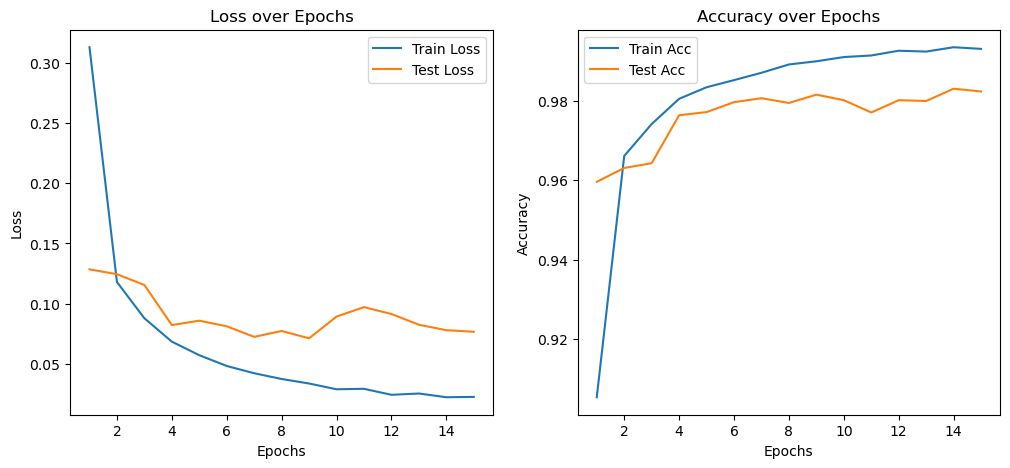

In [35]:
# Now we can create model instance, define loss function and optimizer
HYPERPARAMS = {
    'hidden_layers': [512, 256, 128, 64],
    'learning_rate': 0.001,
    'activation_fn': nn.ReLU,           
    'num_epochs': 15,
    'batch_size': 64,
    'optimizer_class': optim.Adam,     
    'criterion_class': nn.CrossEntropyLoss,  
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'show_plots': True,
}

trained_model = train_and_evaluate(**HYPERPARAMS)

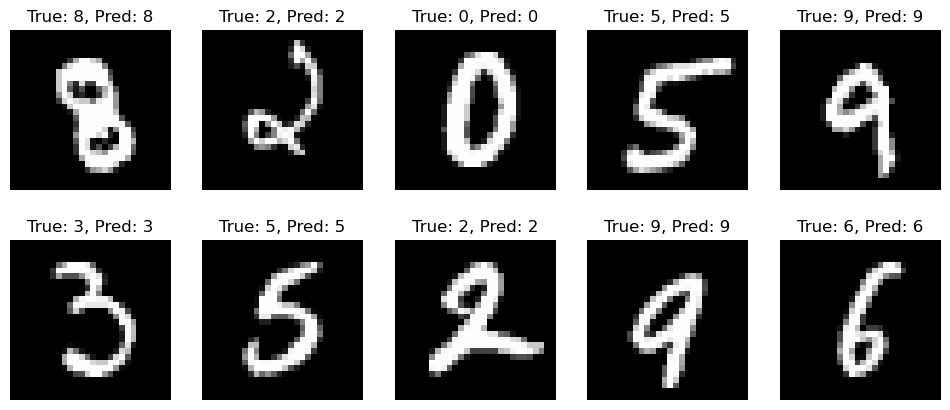

In [36]:
# Lets now make some predictions and plot with images 
# I will choose random 10 images from test dataset

random_indices = random.sample(range(len(test_data)), 10)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
trained_model.eval()
for ax, idx in zip(axes.flatten(), random_indices):
    flat_image, label = test_data[idx]                           
    input_tensor = flat_image.unsqueeze(0).to(HYPERPARAMS['device'])  
    with torch.no_grad():
        output = trained_model(input_tensor)
        pred = output.argmax(dim=1).item()                       
    ax.imshow(flat_image.view(28, 28).cpu(), cmap='gray')         
    ax.set_title(f'True: {int(label)}, Pred: {pred}')
    ax.axis('off')
plt.show()


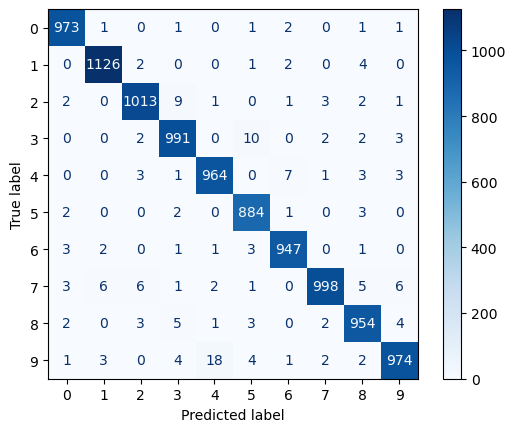

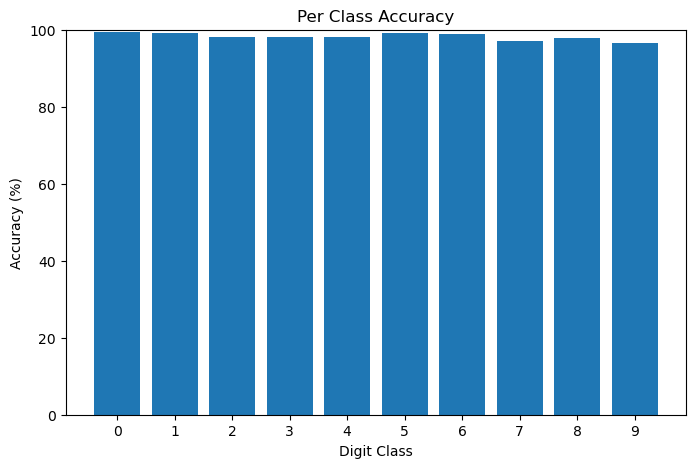

In [37]:
# I want to get confusion matrix for test dataset

all_preds = []
all_labels = []

trained_model.eval()
with torch.no_grad():
    for data, target in DataLoader(test_data, batch_size=1000):
        data, target = data.to(HYPERPARAMS['device']), target.to(HYPERPARAMS['device'])
        output = trained_model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)

# Lets see plot per class accuracy 
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8,5))
plt.bar(range(10), class_accuracy*100)
plt.xlabel('Digit Class')
plt.ylabel('Accuracy (%)')
plt.title('Per Class Accuracy')
plt.xticks(range(10))
plt.ylim(0, 100)
plt.show()

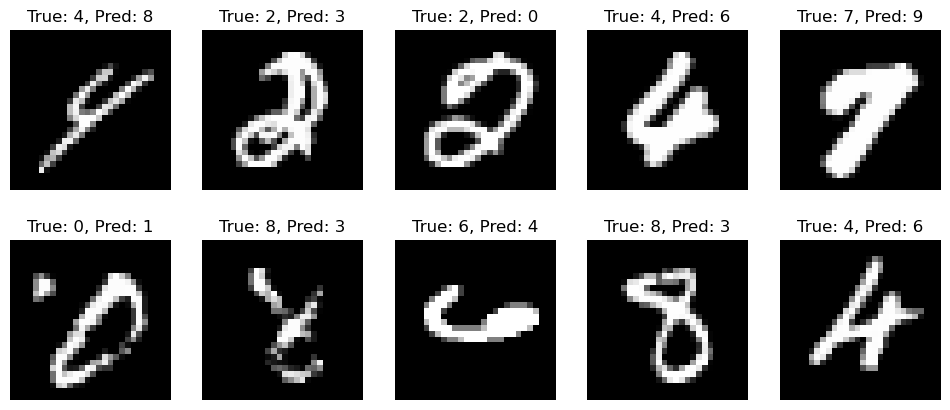

In [38]:
# I got interested about the images that I have predicted wrong because I think they are model independent (some kind of outliers)
# So lets plot them

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
wrong_indices = [i for i, (pred, label) in enumerate(zip(all_preds, all_labels)) if pred != label]
sampled_wrong_indices = random.sample(wrong_indices, 10)
trained_model.eval()
for ax, idx in zip(axes.flatten(), sampled_wrong_indices):
    flat_image, label = test_data[idx]                           
    input_tensor = flat_image.unsqueeze(0).to(HYPERPARAMS['device'])  
    with torch.no_grad():
        output = trained_model(input_tensor)
        pred = output.argmax(dim=1).item()                       
    ax.imshow(flat_image.view(28, 28).cpu(), cmap='gray')         
    ax.set_title(f'True: {int(label)}, Pred: {pred}')
    ax.axis('off')
plt.show()


In [39]:
# WE can see that some digits are really hard to recognize even for human eye
# So now lets make overall conclusion about this homework
total_correct = sum(1 for p, l in zip(all_preds, all_labels) if p == l)
overall_accuracy = total_correct / len(all_labels)*100
print(f'Overall Test Accuracy: {overall_accuracy:.4f}')

Overall Test Accuracy: 98.2400
